## Drug Screening Panels Data Analysis

Import required packages and classes

In [1]:
import pharmacoset
import importlib
import utils
import calculations
import myPlots



In [2]:
importlib.reload(pharmacoset) 
importlib.reload(utils)
importlib.reload(myPlots)
importlib.reload(calculations)

from pharmacoset import PharmacoSet
from utils import Tools, DrugAnalysis
from calculations import Correlation
from myPlots import Plotting

### Create PharmacoSets
PharmacoSet class is defined in pharmacoset.py file.

In [4]:
gdsc2_path = "../../data/processed_data/gdsc2_normalized_mapped.tsv"
gdsc1_path = "../../data/processed_data/gdsc1_normalized_mapped.tsv"

gdsc1 = PharmacoSet(filepath= gdsc1_path, name= "gdsc1")
gdsc2 = PharmacoSet(filepath= gdsc2_path, name= "gdsc2")
gdsc1.data.head()


cell_line           drug      dose  response dataset
0  CVCL_1045  5z7oxozeaenol  0.000000  1.000000   gdsc1
1  CVCL_1045  5z7oxozeaenol  0.039062  0.854962   gdsc1
2  CVCL_1045  5z7oxozeaenol  0.156250  0.812565   gdsc1
3  CVCL_1045  5z7oxozeaenol  0.625000  0.795615   gdsc1
4  CVCL_1045  5z7oxozeaenol  2.500000  0.837670   gdsc1

Find and filter overlapping cell line - drug pairs.
After using filter_common_pairs method, filtered data can be accessed from PharmacoSet object by '.overlapping_data' accessor. 

In [5]:
common_pairs = Tools.find_common_pairs(gdsc1, gdsc2)


In [6]:
print(len(gdsc1.data['cell_line'].unique()))
print(len(gdsc2.data['cell_line'].unique()))
print(len(gdsc1.data['drug'].unique()))
print(len(gdsc2.data['drug'].unique()))

965
964
378
287


In [7]:
import pandas as pd
n_cell = len(pd.DataFrame(list(common_pairs))['cell_line'].unique())
n_drug = len(pd.DataFrame(list(common_pairs))['drug'].unique())
print(f"Number of overlapping cells: {n_cell}")
print(f"Number of overlapping drugs: {n_drug}")

Number of overlapping cells: 955
Number of overlapping drugs: 122


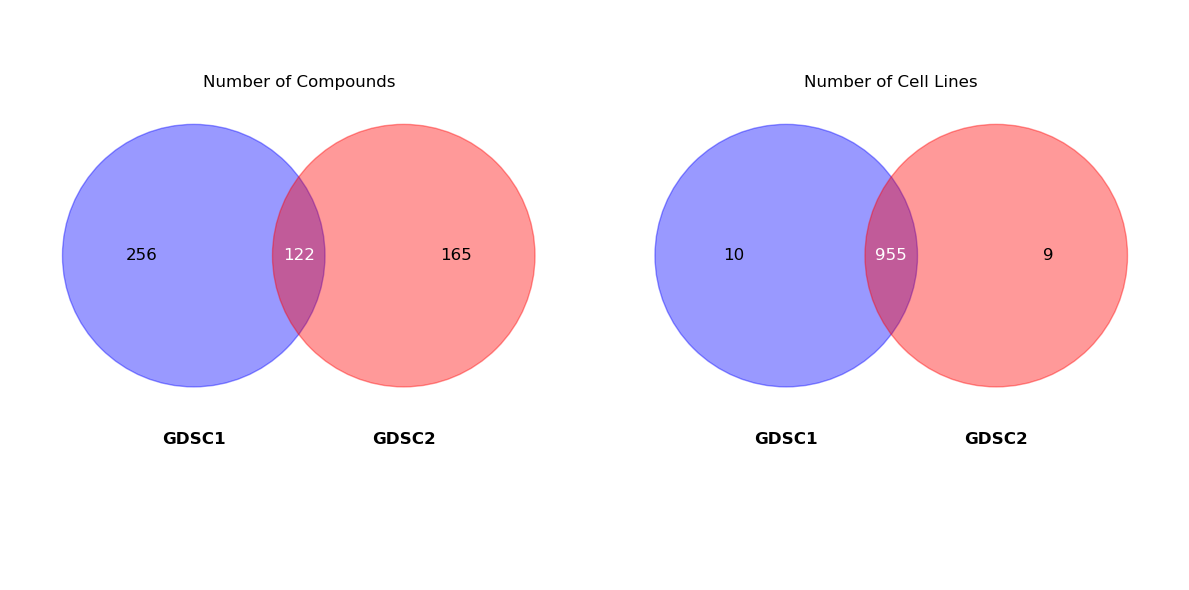

In [8]:
import matplotlib.pyplot as plt

def plot_fixed_venn(subsets, set_labels, ax, title):
    # Draw circles
    circle1 = plt.Circle((-0.4, 0), 0.5, color='blue', alpha=0.4)
    circle2 = plt.Circle((0.4, 0), 0.5, color='red', alpha=0.4)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    
    # Annotate
    ax.annotate(subsets[0], (-0.6, 0), ha='center', va='center', fontsize=12)
    ax.annotate(subsets[1], (0.6, 0), ha='center', va='center', fontsize=12)
    ax.annotate(subsets[2], (0, 0), ha='center', va='center', fontsize=12, color='white')

    # Add set labels (GDSC1 and GDSC2)
    ax.annotate(set_labels[0], (-0.4, -0.7), ha='center', va='center', fontsize=12, fontweight='bold')
    ax.annotate(set_labels[1], (0.4, -0.7), ha='center', va='center', fontsize=12, fontweight='bold')

    # Set title
    ax.set_title(title, y=0.85)  # Move title closer to the Venn diagram

    # Configure axes
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-0.9, 0.6)
    ax.set_aspect('equal', adjustable='datalim')
    ax.axis('off')  # Hide axis

# Data
cell_lines_data = (965 - 955, 964 - 955, 955)
drugs_data = (378 - 122, 287 - 122, 122)

# Plot
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
plot_fixed_venn(cell_lines_data, ('GDSC1', 'GDSC2'), axarr[1], 'Number of Cell Lines')
plot_fixed_venn(drugs_data, ('GDSC1', 'GDSC2'), axarr[0], 'Number of Compounds')
plt.tight_layout()
plt.show()


In [9]:
gdsc1.filter_common_pairs(common_pairs)
gdsc2.filter_common_pairs(common_pairs)

Find common concetration range of the overlapping data.

In [10]:
common_conc = Tools.common_concentration_ranges(gdsc1.overlapping_data, gdsc2.overlapping_data)
common_conc.head()


cell_line_          drug_  common_min_dose  common_max_dose
0  cvcl_0001  5fluorouracil         0.125000           20.000
1  cvcl_0001       afatinib         0.002001            4.000
2  cvcl_0001        agi6780         0.010005            0.512
3  cvcl_0001      alisertib         0.010000            2.560
4  cvcl_0001    avagacestat         0.019531           10.000

Compute AUC between shared concentration range for all drugs across all cell lines for both GDSC1 and GDSC2.  
- I used the output curve parameters from CurveCurator to compute AUC values.  
- AUC value for a given cell - drug pairs are computed in shared concentration range.
- I used p_value and log_fc as QC metric to throw out the curves that does not satisfy the basic assumptions.

!!!!!!!! Note: 

Below chunk takes too much time, so I wrote the output dataframe in csv, which can be found in ./recomputed_aucs/

So, you can skip this chunk, in the next chunk it will be read from csv.

In [35]:
from joblib import Parallel, delayed

# Define your function to call
def worker(obj, method_name, kwargs):
    return getattr(obj, method_name)(**kwargs)

# Prepare your arguments
args = [
    (gdsc1, 'get_recomp_auc_values', {'common_concentration': common_conc, 'p_filter': 0.05, 'log_fc': -0.5}),
    (gdsc2, 'get_recomp_auc_values', {'common_concentration': common_conc, 'p_filter': 0.05, 'log_fc': -0.5})
]

# Create a pool of workers
results = Parallel(n_jobs=8)(delayed(worker)(*arg) for arg in args)

# Unpack results
all_drug_gdsc1, all_drug_gdsc2 = results


In [20]:
gdsc1.recomp_Aucs = pd.read_csv("../../data/recomputed_aucs/gdsc1_recomputed_Auc.csv")
gdsc2.recomp_Aucs = pd.read_csv("../../data/recomputed_aucs/gdsc2_recomputed_Auc.csv")
gdsc2.recomp_Aucs.head()

drug  cvcl_0001  cvcl_0002  cvcl_0005  cvcl_0006  cvcl_0008  \
0  5fluorouracil   0.199403   0.164385   0.280584   0.297988   0.271871   
1        agi6780        NaN        NaN        NaN        NaN        NaN   
2        azd1208        NaN        NaN        NaN        NaN        NaN   
3        azd1332        NaN        NaN        NaN        NaN   0.011011   
4        azd2014   0.203614        NaN        NaN        NaN   0.426107   

   cvcl_0013     cvcl_0014  cvcl_0017     cvcl_0023  ...  cvcl_1339  \
0   0.208831  3.773064e-01   0.259917  2.597614e-01  ...        NaN   
1        NaN  5.608847e-12        NaN  2.567024e-11  ...        NaN   
2        NaN           NaN        NaN           NaN  ...        NaN   
3        NaN           NaN   0.012681  1.271613e-01  ...        NaN   
4        NaN  3.660046e-01   0.415733  4.666434e-01  ...        NaN   

   cvcl_1420  cvcl_1451  cvcl_1733  cvcl_1367  cvcl_1781  cvcl_2411  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

   cvcl_1189  cvcl_1552  cvcl_1659  
0        NaN        NaN        NaN  
1        NaN        NaN        NaN  
2        NaN        NaN        NaN  
3        NaN        NaN        NaN  
4        NaN        NaN        NaN  

[5 rows x 956 columns]

In [21]:
print(len(gdsc1.get_pub_AUC_values()['drug'].unique()))
print(len(gdsc1.overlapping_data['drug'].unique()))

122
122


Plot the distribution of AUC values of Published and Recomputed for a given dataset. 
GDSC1 below

In [ ]:
Plotting.plot_AUC_dist_pub_vs_recomp(gdsc1)

Plot the distribution of AUC values of Published and Recomputed for a given dataset. GDSC2 below.

In [ ]:
Plotting.plot_AUC_dist_pub_vs_recomp(gdsc2)

Check the overall correlation between CCLE and GDSC published AUC values

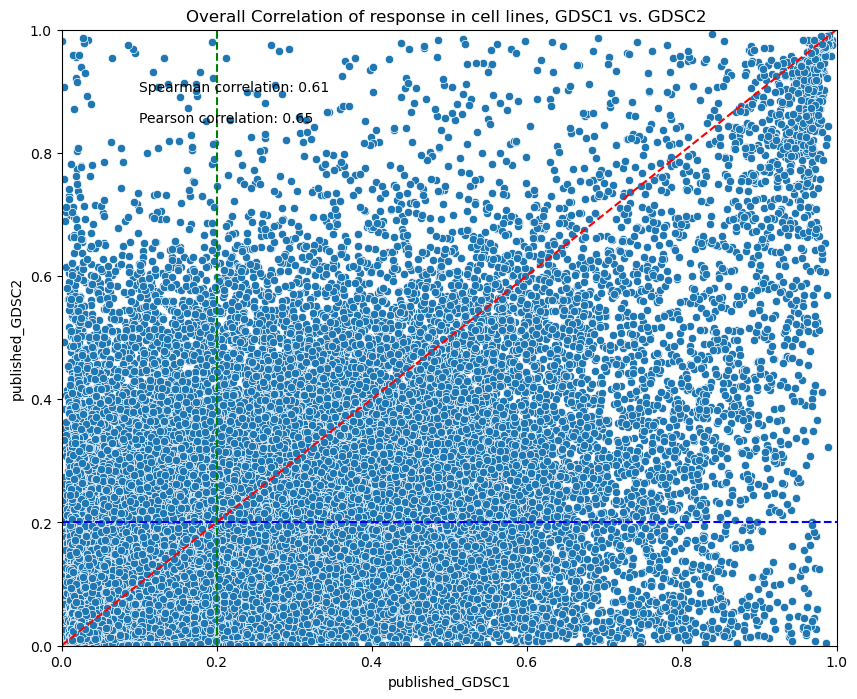

In [18]:
Plotting.correlation_plot_whole_pSet(gdsc1, gdsc2, "published")

Check overall correlation between Recomputed AUC values.  
As it can be seen, only using CurveCurator resulted in better consistency.

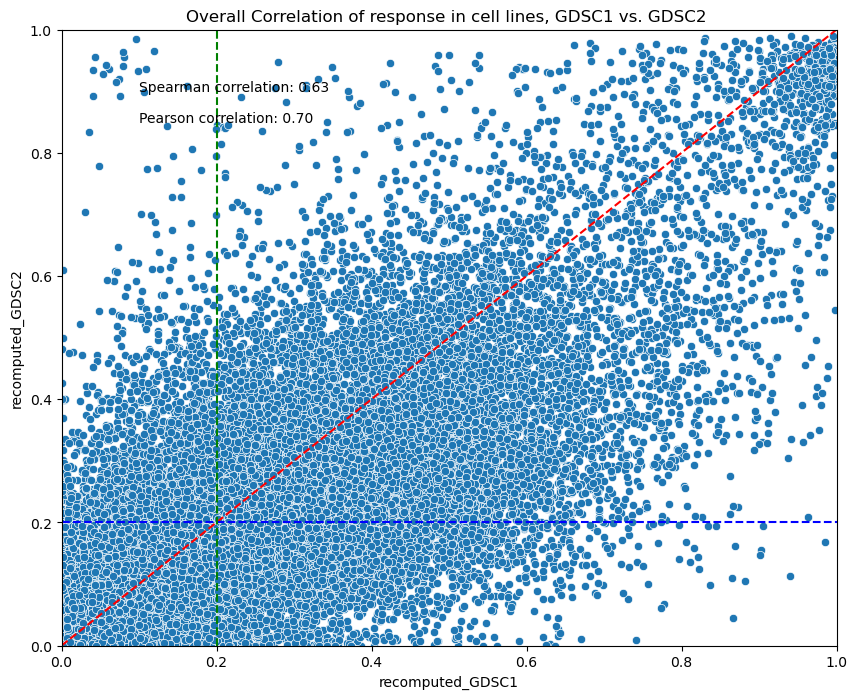

In [22]:
Plotting.correlation_plot_whole_pSet(gdsc1, gdsc2, "recomputed")

I'll compute the correlation for each drug seperately, and create a table.

In [23]:
res_pearson = Correlation.recomp_vs_pub_corr_table(gdsc1, gdsc2, "pearson")
res_pearson = res_pearson[(res_pearson['pub_size'] > 20) & (res_pearson['recomp_size'] > 20)]
res_pearson

c:\Users\SerhatBeyaz\TUM\pharmaco-analysis\Python scripts\calculations.py:96: RuntimeWarning: divide by zero encountered in arctanh
  z2_recomp = np.arctanh(correlation_coef_recomp[0])
c:\Users\SerhatBeyaz\TUM\pharmaco-analysis\Python scripts\calculations.py:99: RuntimeWarning: invalid value encountered in sqrt
  SE_diff = np.sqrt((1 / (size_pub - 3)) + (1 / (size_recomp - 3)))
c:\Users\SerhatBeyaz\TUM\pharmaco-analysis\Python scripts\calculations.py:96: RuntimeWarning: divide by zero encountered in arctanh
  z2_recomp = np.arctanh(correlation_coef_recomp[0])
c:\Users\SerhatBeyaz\TUM\pharmaco-analysis\Python scripts\calculations.py:99: RuntimeWarning: invalid value encountered in sqrt
  SE_diff = np.sqrt((1 / (size_pub - 3)) + (1 / (size_recomp - 3)))


drug  pub_corr  recomp_corr pub_size recomp_size   p-value
0    5fluorouracil  0.605955     0.578571      897         224  0.574357
1          azd1332  0.711146     0.749336      694         236  0.279407
2          azd2014  0.403375     0.395906      695         506  0.879429
3          azd4547  0.627714     0.836569      917         100  0.000010
4          azd5438  0.373684     0.373440      692         550  0.996049
..             ...       ...          ...      ...         ...       ...
98      paclitaxel  0.223886     0.513793      383         216  0.000071
99       rapamycin  0.190516     0.138646      342          29  0.793281
100      sorafenib  0.454941     0.687152      384         248  0.000018
101          mg132  0.327994     0.387681      393          74  0.595554
102     tozasertib  0.527595     0.471343      103          30  0.729447

[91 rows x 6 columns]

In [24]:
res_pearson['diff'] = res_pearson['recomp_corr'] - res_pearson['pub_corr']
res_pearson.sort_values(by="recomp_corr", ascending=False)
res_pearson = res_pearson[res_pearson['p-value'] < 0.05]

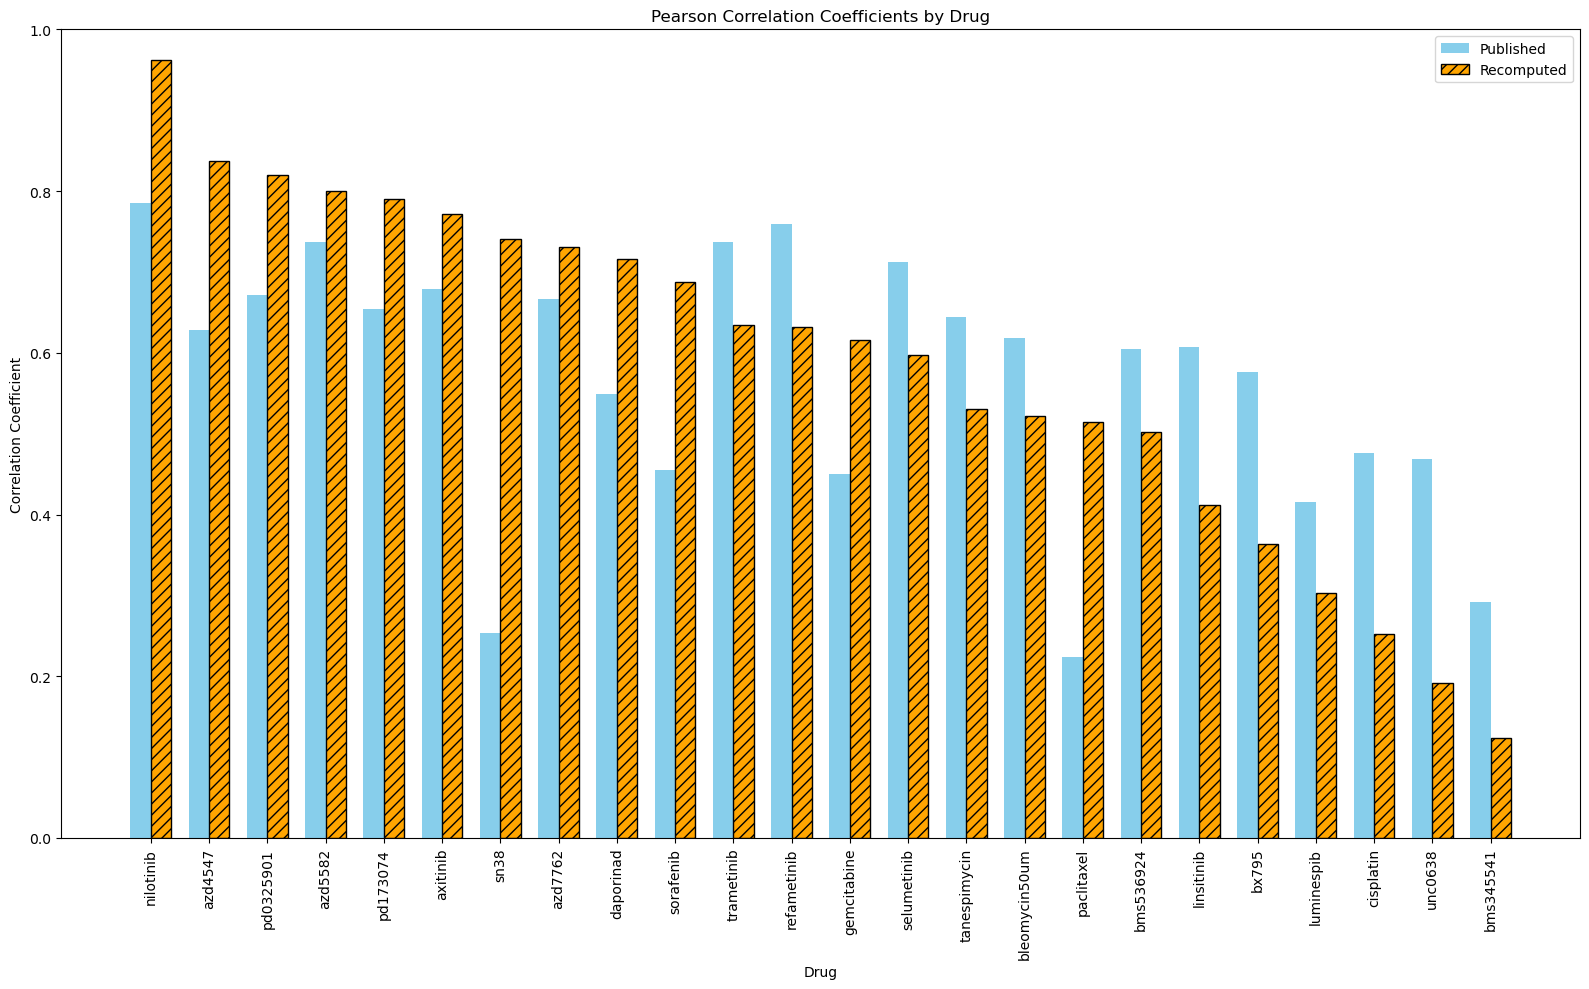

In [25]:
Plotting.barplot_corr_table(res_pearson, "Pearson")

The most significant difference between published and recomputed is SN38 
To see how it looks like in scatter plot, I will plot only sn38.  

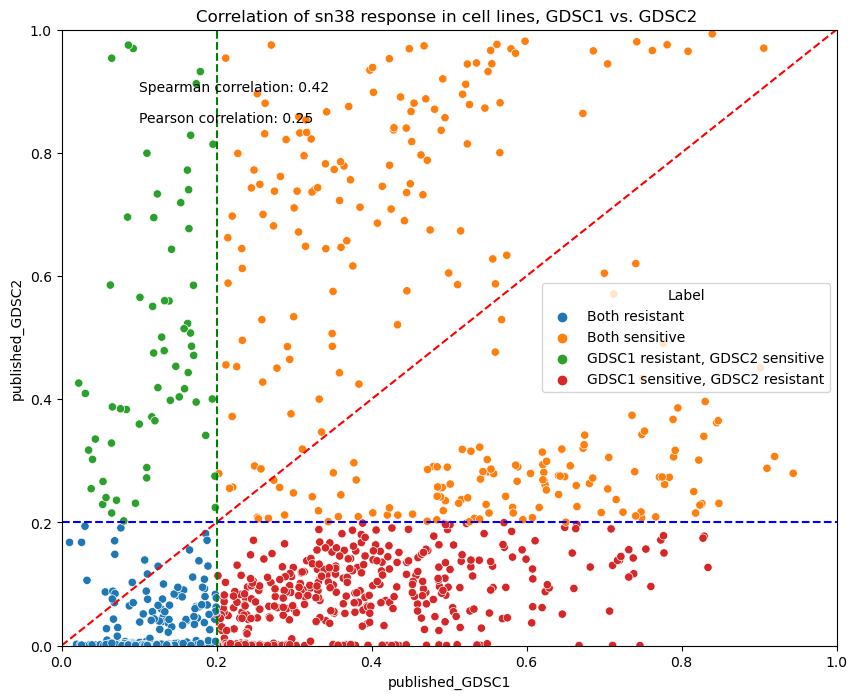

In [27]:
Plotting.correlation_plot(gdsc1, gdsc2, "sn38", method= 'published')

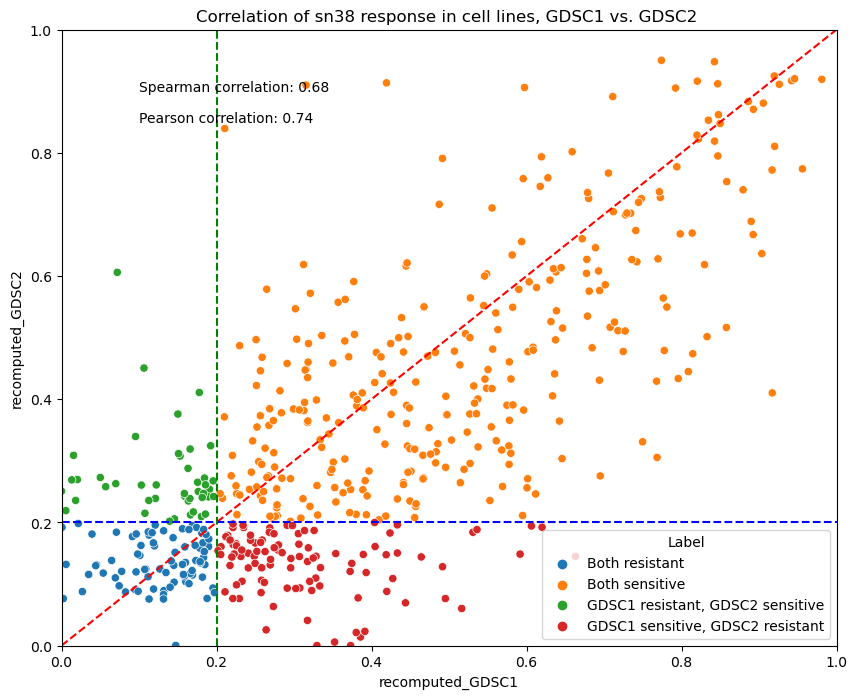

In [28]:
Plotting.correlation_plot(gdsc1, gdsc2, "sn38", method= 'recomputed')

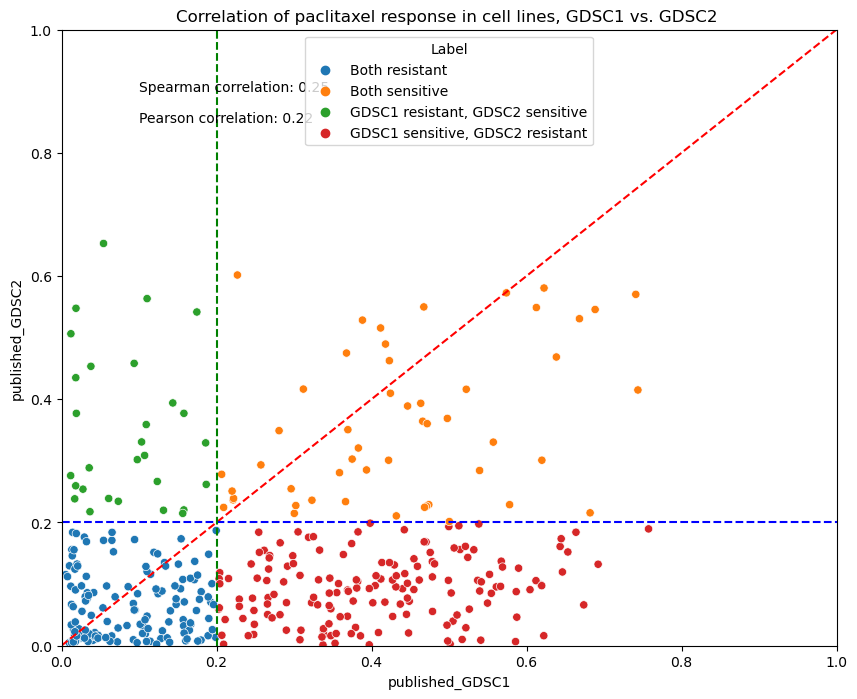

In [29]:
Plotting.correlation_plot(gdsc1, gdsc2, "paclitaxel", method= 'published')

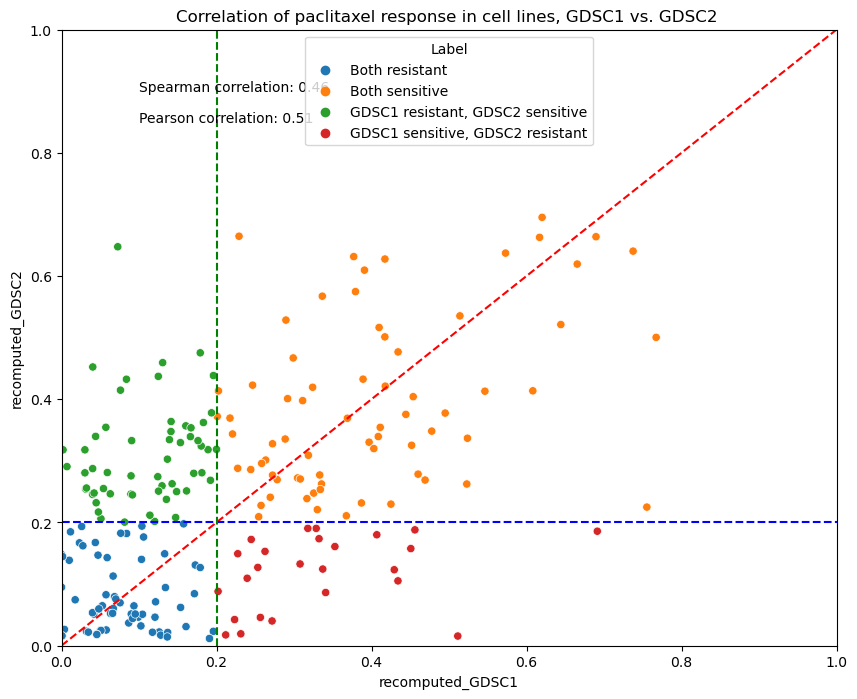

In [30]:
Plotting.correlation_plot(gdsc1, gdsc2, "paclitaxel", method= 'recomputed')

## In-depth look at variance across AUC values 

In [41]:
importlib.reload(pharmacoset) 
importlib.reload(utils)
importlib.reload(myPlots)

from pharmacoset import PharmacoSet
from utils import Tools, DrugAnalysis
from calculations import Correlation
from myPlots import Plotting

In [ ]:
#Plotting.plot_waterfall(gdsc.recomp_Aucs, 'irinotecan')

In [ ]:
#Plotting.plot_waterfall(ccle.recomp_Aucs, 'irinotecan')

Filter the overlapping drug-cell line pairs across published and recomputed datasets so that we can better compare published vs recomputed AUCs.

In [31]:

pub_gdsc1, recomp_gdsc1 = calculations.fetch_data(gdsc1)
pub_gdsc2, recomp_gdsc2 = calculations.fetch_data(gdsc2)

pub_gdsc1.columns= pub_gdsc1.columns.str.lower()
pub_gdsc2.columns= pub_gdsc2.columns.str.lower()


In [32]:

pub_gdsc1_melt = pub_gdsc1.melt(id_vars=['drug'], var_name='cell_line', value_name='auc')
pub_gdsc2_melt = pub_gdsc2.melt(id_vars=['drug'], var_name='cell_line', value_name='auc')
recomp_gdsc1_melt = recomp_gdsc1.melt(id_vars=['drug'], var_name='cell_line', value_name='auc')
recomp_gdsc2_melt = recomp_gdsc2.melt(id_vars=['drug'], var_name='cell_line', value_name='auc')

In [33]:
pub_merged = pd.merge(pub_gdsc1_melt, pub_gdsc2_melt, how = 'inner' , on = ['drug', 'cell_line'], suffixes= ['_pset1_pub', '_pset2_pub']).dropna(subset= ['auc_pset1_pub', 'auc_pset2_pub'])
print(len(pub_merged['cell_line'].unique()))
print(len(pub_merged['drug'].unique()))

955
122


In [34]:
recomp_merged = pd.merge(recomp_gdsc1_melt, recomp_gdsc2_melt, how = 'inner' , on = ['drug', 'cell_line'], suffixes= ['_pset1', '_pset2']).dropna(subset= ['auc_pset1', 'auc_pset2'])
print(len(recomp_merged['cell_line'].unique()))
print(len(recomp_merged['drug'].unique()))

955
109


In [35]:
all_merged = pd.merge(pub_merged, recomp_merged, how= 'inner', on= ['drug', 'cell_line'])
all_merged

drug  cell_line  auc_pset1_pub  auc_pset2_pub  auc_pset1  \
0      paclitaxel  cvcl_1368       0.280675       0.348901   0.246528   
1       sorafenib  cvcl_1368       0.077456       0.153923   0.024384   
2      tozasertib  cvcl_1368       0.512632       0.605512   0.486680   
3          bi2536  cvcl_1368       0.373264       0.364594   0.355352   
4      entinostat  cvcl_1368       0.330559       0.449540   0.349808   
...           ...        ...            ...            ...        ...   
25699      yk4279  cvcl_0041       0.241078       0.153574   0.241582   
25700     azd6738  cvcl_0041       0.394964       0.179358   0.404526   
25701     azd5438  cvcl_0041       0.229254       0.101010   0.208952   
25702     azd5582  cvcl_0041       0.250001       0.152843   0.204200   
25703     azd2014  cvcl_0041       0.424477       0.087775   0.444126   

       auc_pset2  
0       0.422769  
1       0.060794  
2       0.544172  
3       0.339276  
4       0.434424  
...          ...  
25699   0.164092  
25700   0.226510  
25701   0.026834  
25702   0.106861  
25703   0.153416  

[25704 rows x 6 columns]

I will calculate absolute difference between published AUC values and create a heatmap. So that I can see which drug-cell line pairs are differing (inconsistent) most for their AUC values.  
Note: This is not the best way to quantify the difference, since the curves could be quite different but have the same AUC values.  
But since we don't have the curve parameters for published AUCs, it is the only way to compare the published ones.

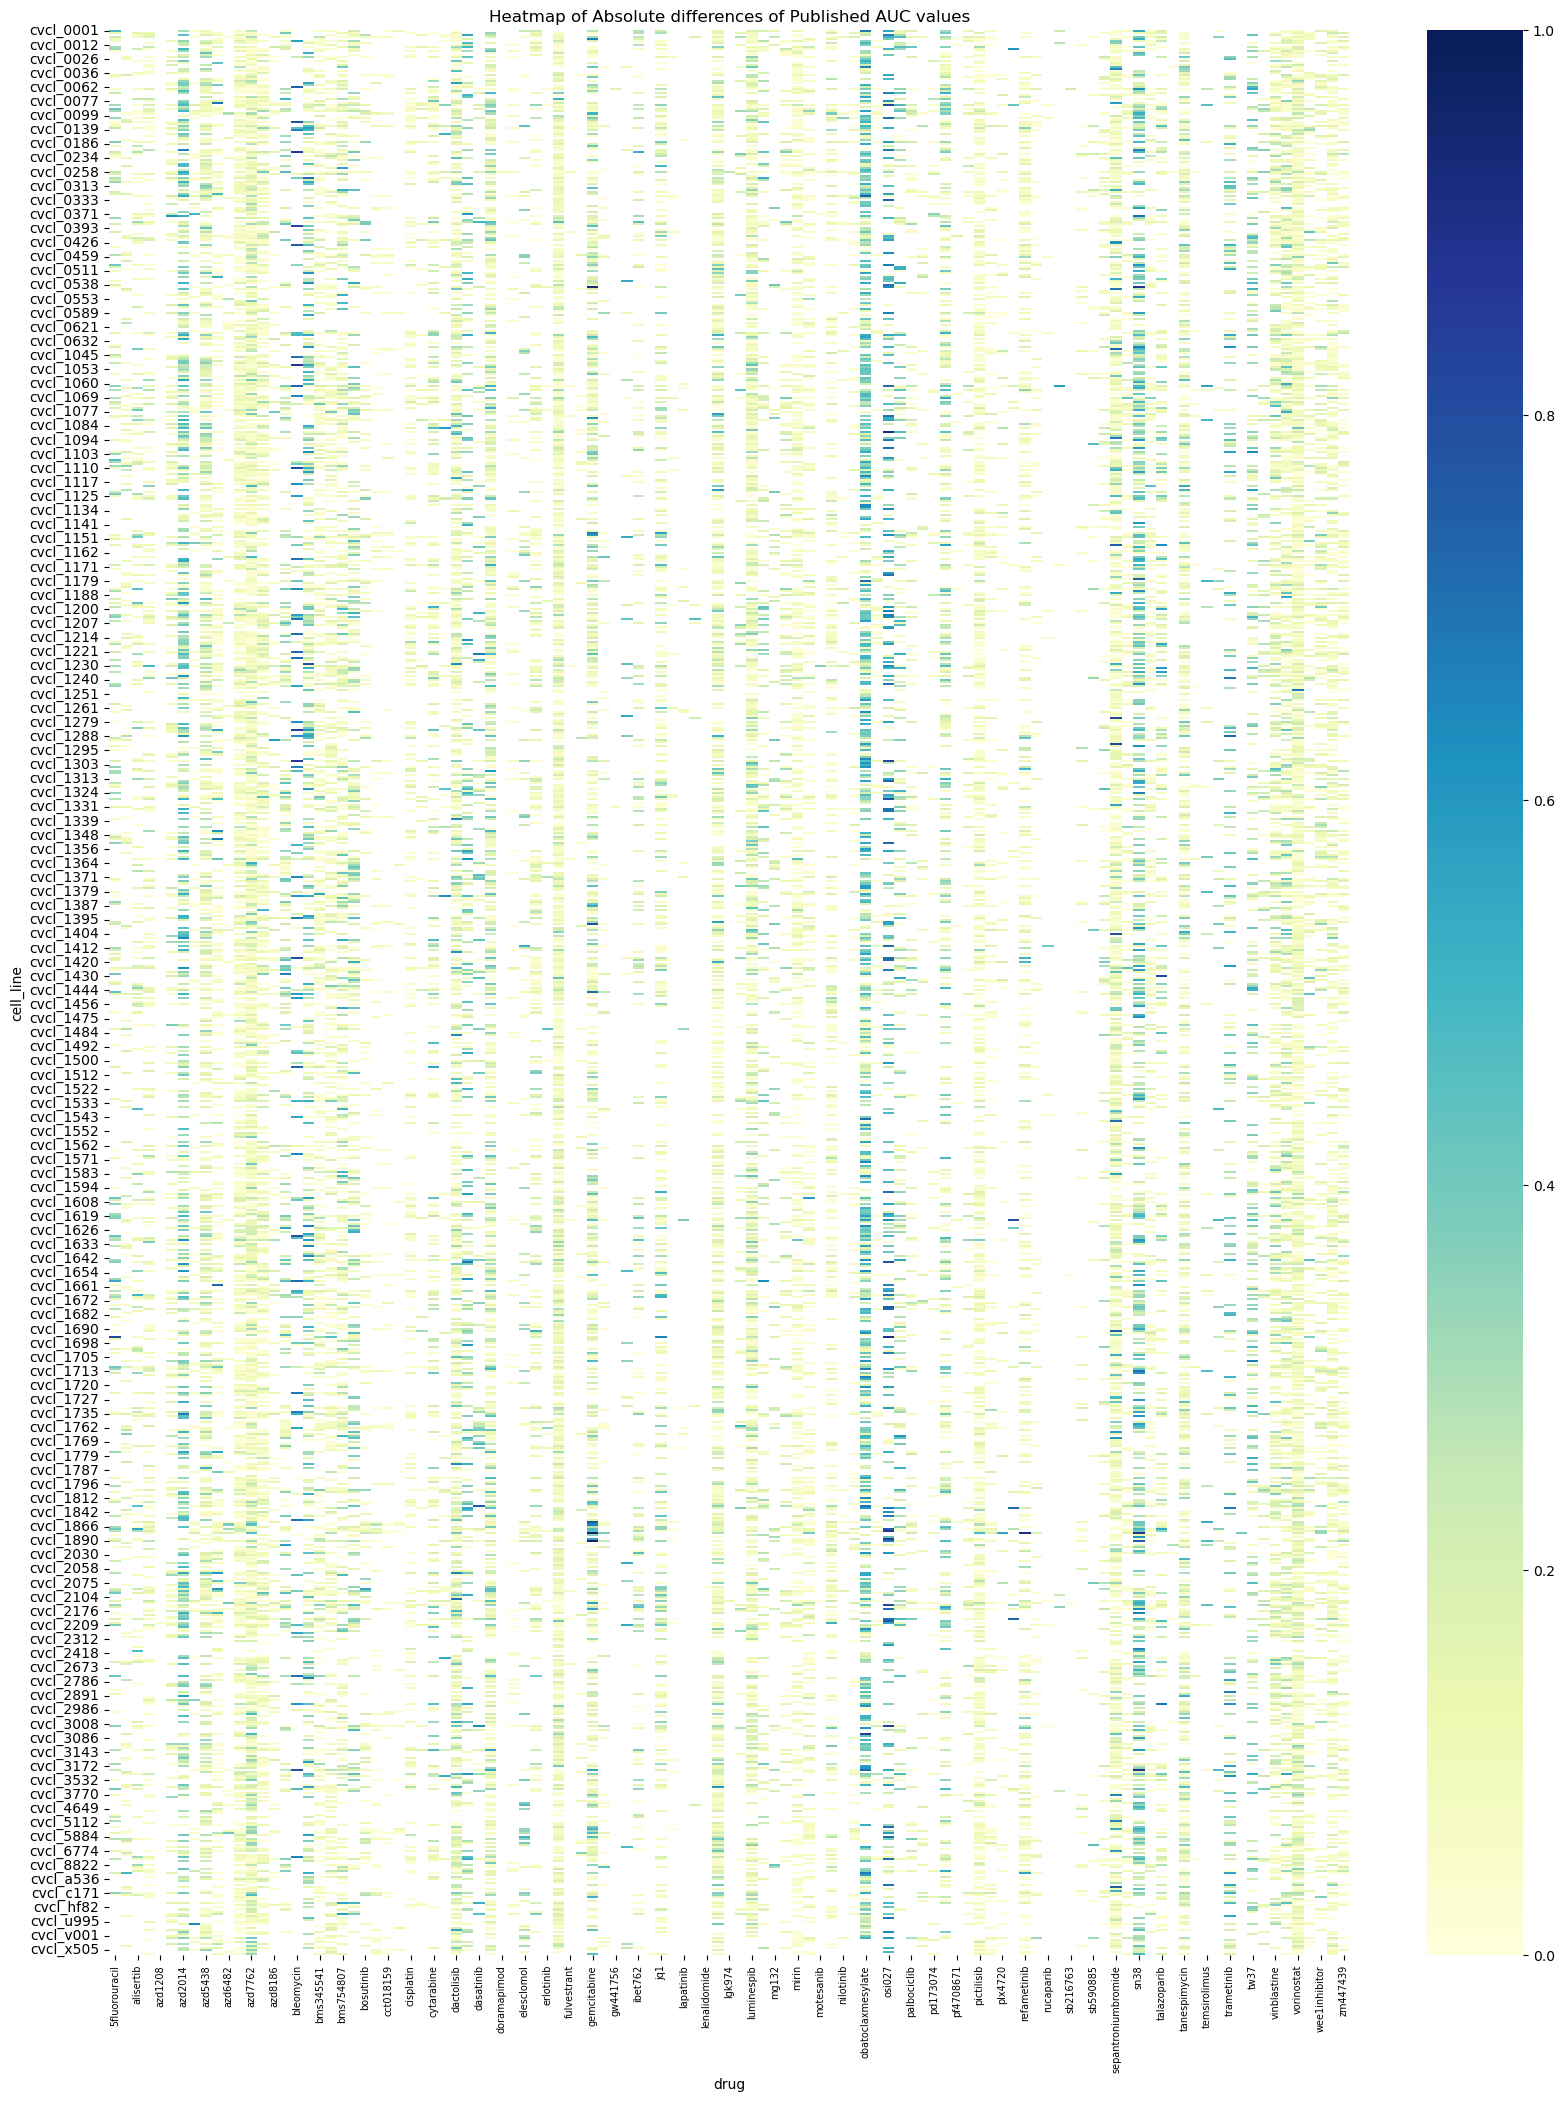

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

df = all_merged.copy()


df['abs_diff_pub'] = abs(df['auc_pset1_pub'] - df['auc_pset2_pub'])
df['abs_diff_recomp'] = abs(df['auc_pset1'] - df['auc_pset2'])

# Pivot the DataFrame to prepare for the heatmap
df_pivot = df.pivot_table(values='abs_diff_pub', index='cell_line', columns='drug')



plt.figure(figsize=(20, 25))
sns.heatmap(df_pivot, annot=False, cmap="YlGnBu", vmin=0, vmax=1)
plt.xticks(fontsize = 7)
plt.title('Heatmap of Absolute differences of Published AUC values')
plt.show()




I will do the same for the Recomputed values so that I can see which cell-drugs get better and which does not.

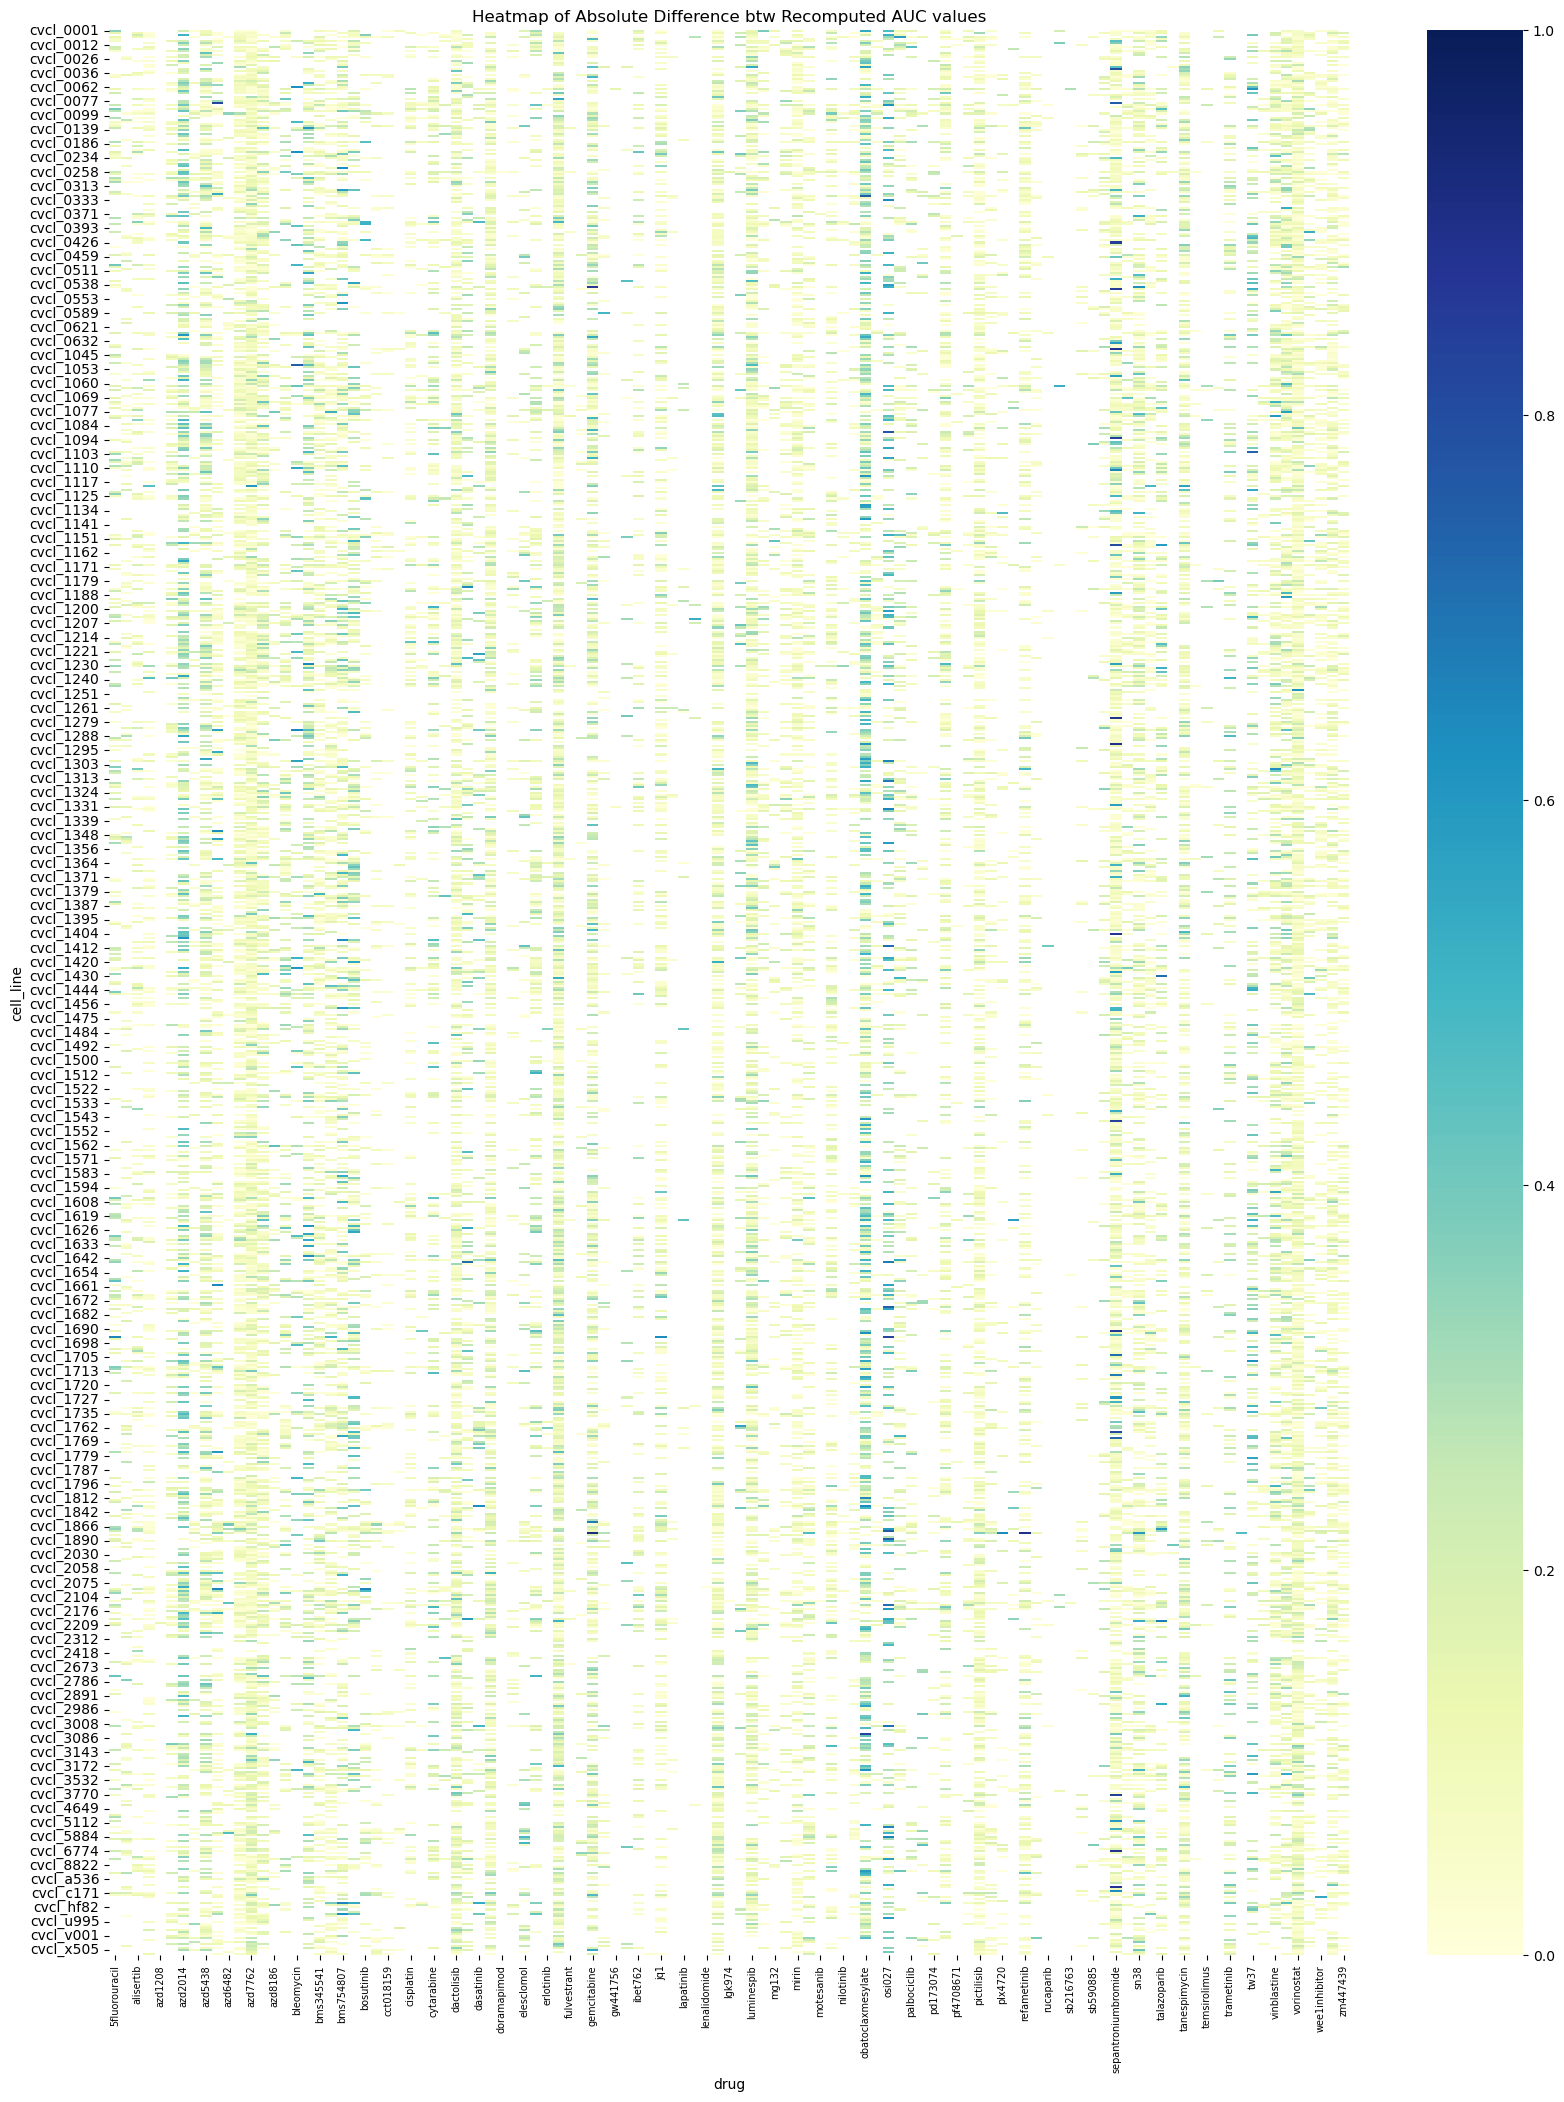

In [48]:
# Pivot the DataFrame to prepare for the heatmap
df_pivot = df.pivot_table(values='abs_diff_recomp', index='cell_line', columns='drug')



plt.figure(figsize=(20, 25))
sns.heatmap(df_pivot, annot=False, cmap="YlGnBu", vmin=0, vmax=1)
plt.xticks(fontsize = 7)
plt.title('Heatmap of Absolute Difference btw Recomputed AUC values')
plt.show()

Let's check which cell-drug pair got the best improvement from recomputation.

In [49]:
df['diff_of_diff'] = df['abs_diff_pub'] - df['abs_diff_recomp']
df.sort_values(by=['diff_of_diff'], ascending=False)

drug  cell_line  auc_pset1_pub  auc_pset2_pub  auc_pset1  \
11311  gemcitabine  cvcl_1865       0.239072       0.898820   0.800127   
3635   gemcitabine  cvcl_1890       0.029005       0.977558   0.533321   
3676          sn38  cvcl_1890       0.211838       0.953671   0.658855   
7755          sn38  cvcl_1660       0.195528       0.813924   0.637936   
17978  gemcitabine  cvcl_1147       0.293793       0.968537   0.776031   
...            ...        ...            ...            ...        ...   
15452    daporinad  cvcl_1625       0.519584       0.411726   0.210587   
8909   gemcitabine  cvcl_x505       0.256223       0.330443   0.620696   
1086     bleomycin  cvcl_1793       0.203853       0.214526   0.048800   
22619    daporinad  cvcl_2206       0.582706       0.547573   0.348828   
2084     bleomycin  cvcl_1424       0.169448       0.221194   0.001669   

       auc_pset2  abs_diff_pub  abs_diff_recomp  diff_of_diff  
11311   0.790612      0.659748         0.009515      0.650233  
3635    0.868717      0.948553         0.335396      0.613157  
3676    0.801683      0.741833         0.142828      0.599005  
7755    0.606544      0.618396         0.031392      0.587004  
17978   0.871996      0.674744         0.095965      0.578779  
...          ...           ...              ...           ...  
15452   0.766461      0.107858         0.555875     -0.448017  
8909    0.074988      0.074220         0.545707     -0.471487  
1086    0.543155      0.010673         0.494356     -0.483682  
22619   0.938483      0.035133         0.589655     -0.554522  
2084    0.609836      0.051746         0.608167     -0.556421  

[25704 rows x 9 columns]

The best improvement is found to be in CVCL_1865 treated with gemcitabine.  


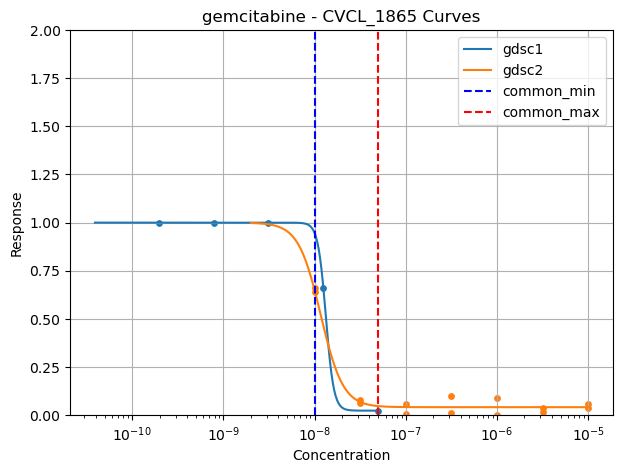

In [36]:
Plotting.plot_sigmoid_curves(gdsc1, gdsc2, 'gemcitabine', 'CVCL_1865', common_conc= common_conc)

Irinotecan - CVCL_0555 got worse after recomputation.  
When you check why by plotting curves below based on refitted parameters, it is obvious that we need to define a new metric to quantify consistency between recomputed values. 

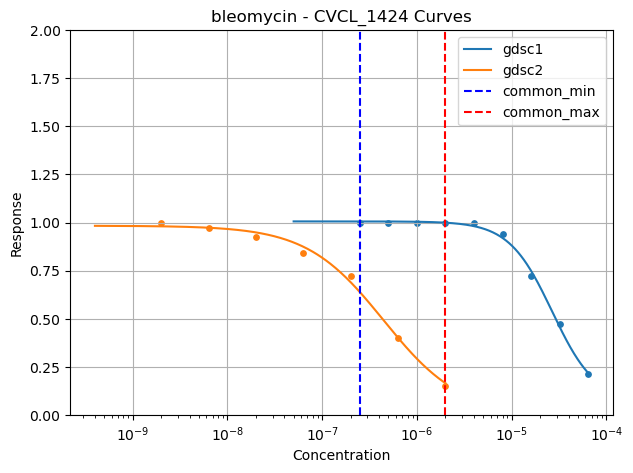

In [37]:
Plotting.plot_sigmoid_curves(gdsc1, gdsc2, 'bleomycin', 'CVCL_1424', common_conc= common_conc)

Below, I'm going to calculate Area Between Curve (ABC) as a measure of consistency.  
It is basically, the integral of the absolute differences of the two curves (abs_diff_func = lambda x: np.abs(f1(x) - f2(x)))  
normalized over shared concentration range, so it has unit 'length'.  
  
In other word, it shows average distance between the points of the two curves.  
It's between 0-1:  
0 = perfect consistency, 1 = perfect inconsistency.

In [38]:
def apply_compute_ABC(row, pSet1, pSet2):
    return Tools.compute_ABC(pSet1, pSet2, row['drug'], row['cell_line'], common_conc, abs = True)

recomp_df = recomp_merged.copy() 

recomp_df['ABC'] = recomp_df.apply(apply_compute_ABC, args=(gdsc1, gdsc2), axis=1)

sorted_ABC = recomp_df.sort_values(by = 'ABC', ascending= False)

sorted_ABC


drug  cell_line  auc_pset1  auc_pset2       ABC
100689          gemcitabine  cvcl_1881   0.043070   0.956055  0.913007
100720          refametinib  cvcl_1881   0.040719   0.934184  0.893472
72997   sepantroniumbromide  cvcl_1292   0.096083   0.985381  0.889692
75475   sepantroniumbromide  cvcl_1404   0.061547   0.935433  0.864493
69103   sepantroniumbromide  cvcl_1093   0.070788   0.914473  0.833561
...                     ...        ...        ...        ...       ...
23794           talazoparib  cvcl_1307   0.083553   0.081029  0.003279
40127               azd5582  cvcl_1689   0.044206   0.044470  0.002508
24136            pictilisib  cvcl_1319   0.446526   0.426739  0.002428
98039            elesclomol  cvcl_1472   0.242798   0.239705  0.002088
758                   mirin  cvcl_0012   0.013348   0.012973  0.000890

[25814 rows x 5 columns]

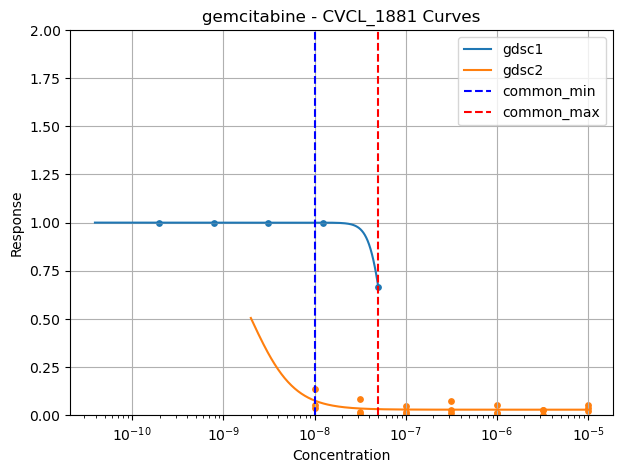

In [41]:
Plotting.plot_sigmoid_curves(gdsc1, gdsc2, 'gemcitabine', 'CVCL_1881', common_conc= common_conc)

Most inconsistent pair below

c:\Users\SerhatBeyaz\TUM\pharmaco-analysis\Python scripts\myPlots.py:317: RuntimeWarning: divide by zero encountered in log10
  concentration_points1 = np.linspace(np.log10(curve1_doses.min() * 2e-7), max_conc1, 400)
c:\Users\SerhatBeyaz\anaconda3\envs\drop2ai\Lib\site-packages\numpy\core\function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
c:\Users\SerhatBeyaz\anaconda3\envs\drop2ai\Lib\site-packages\numpy\core\function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start


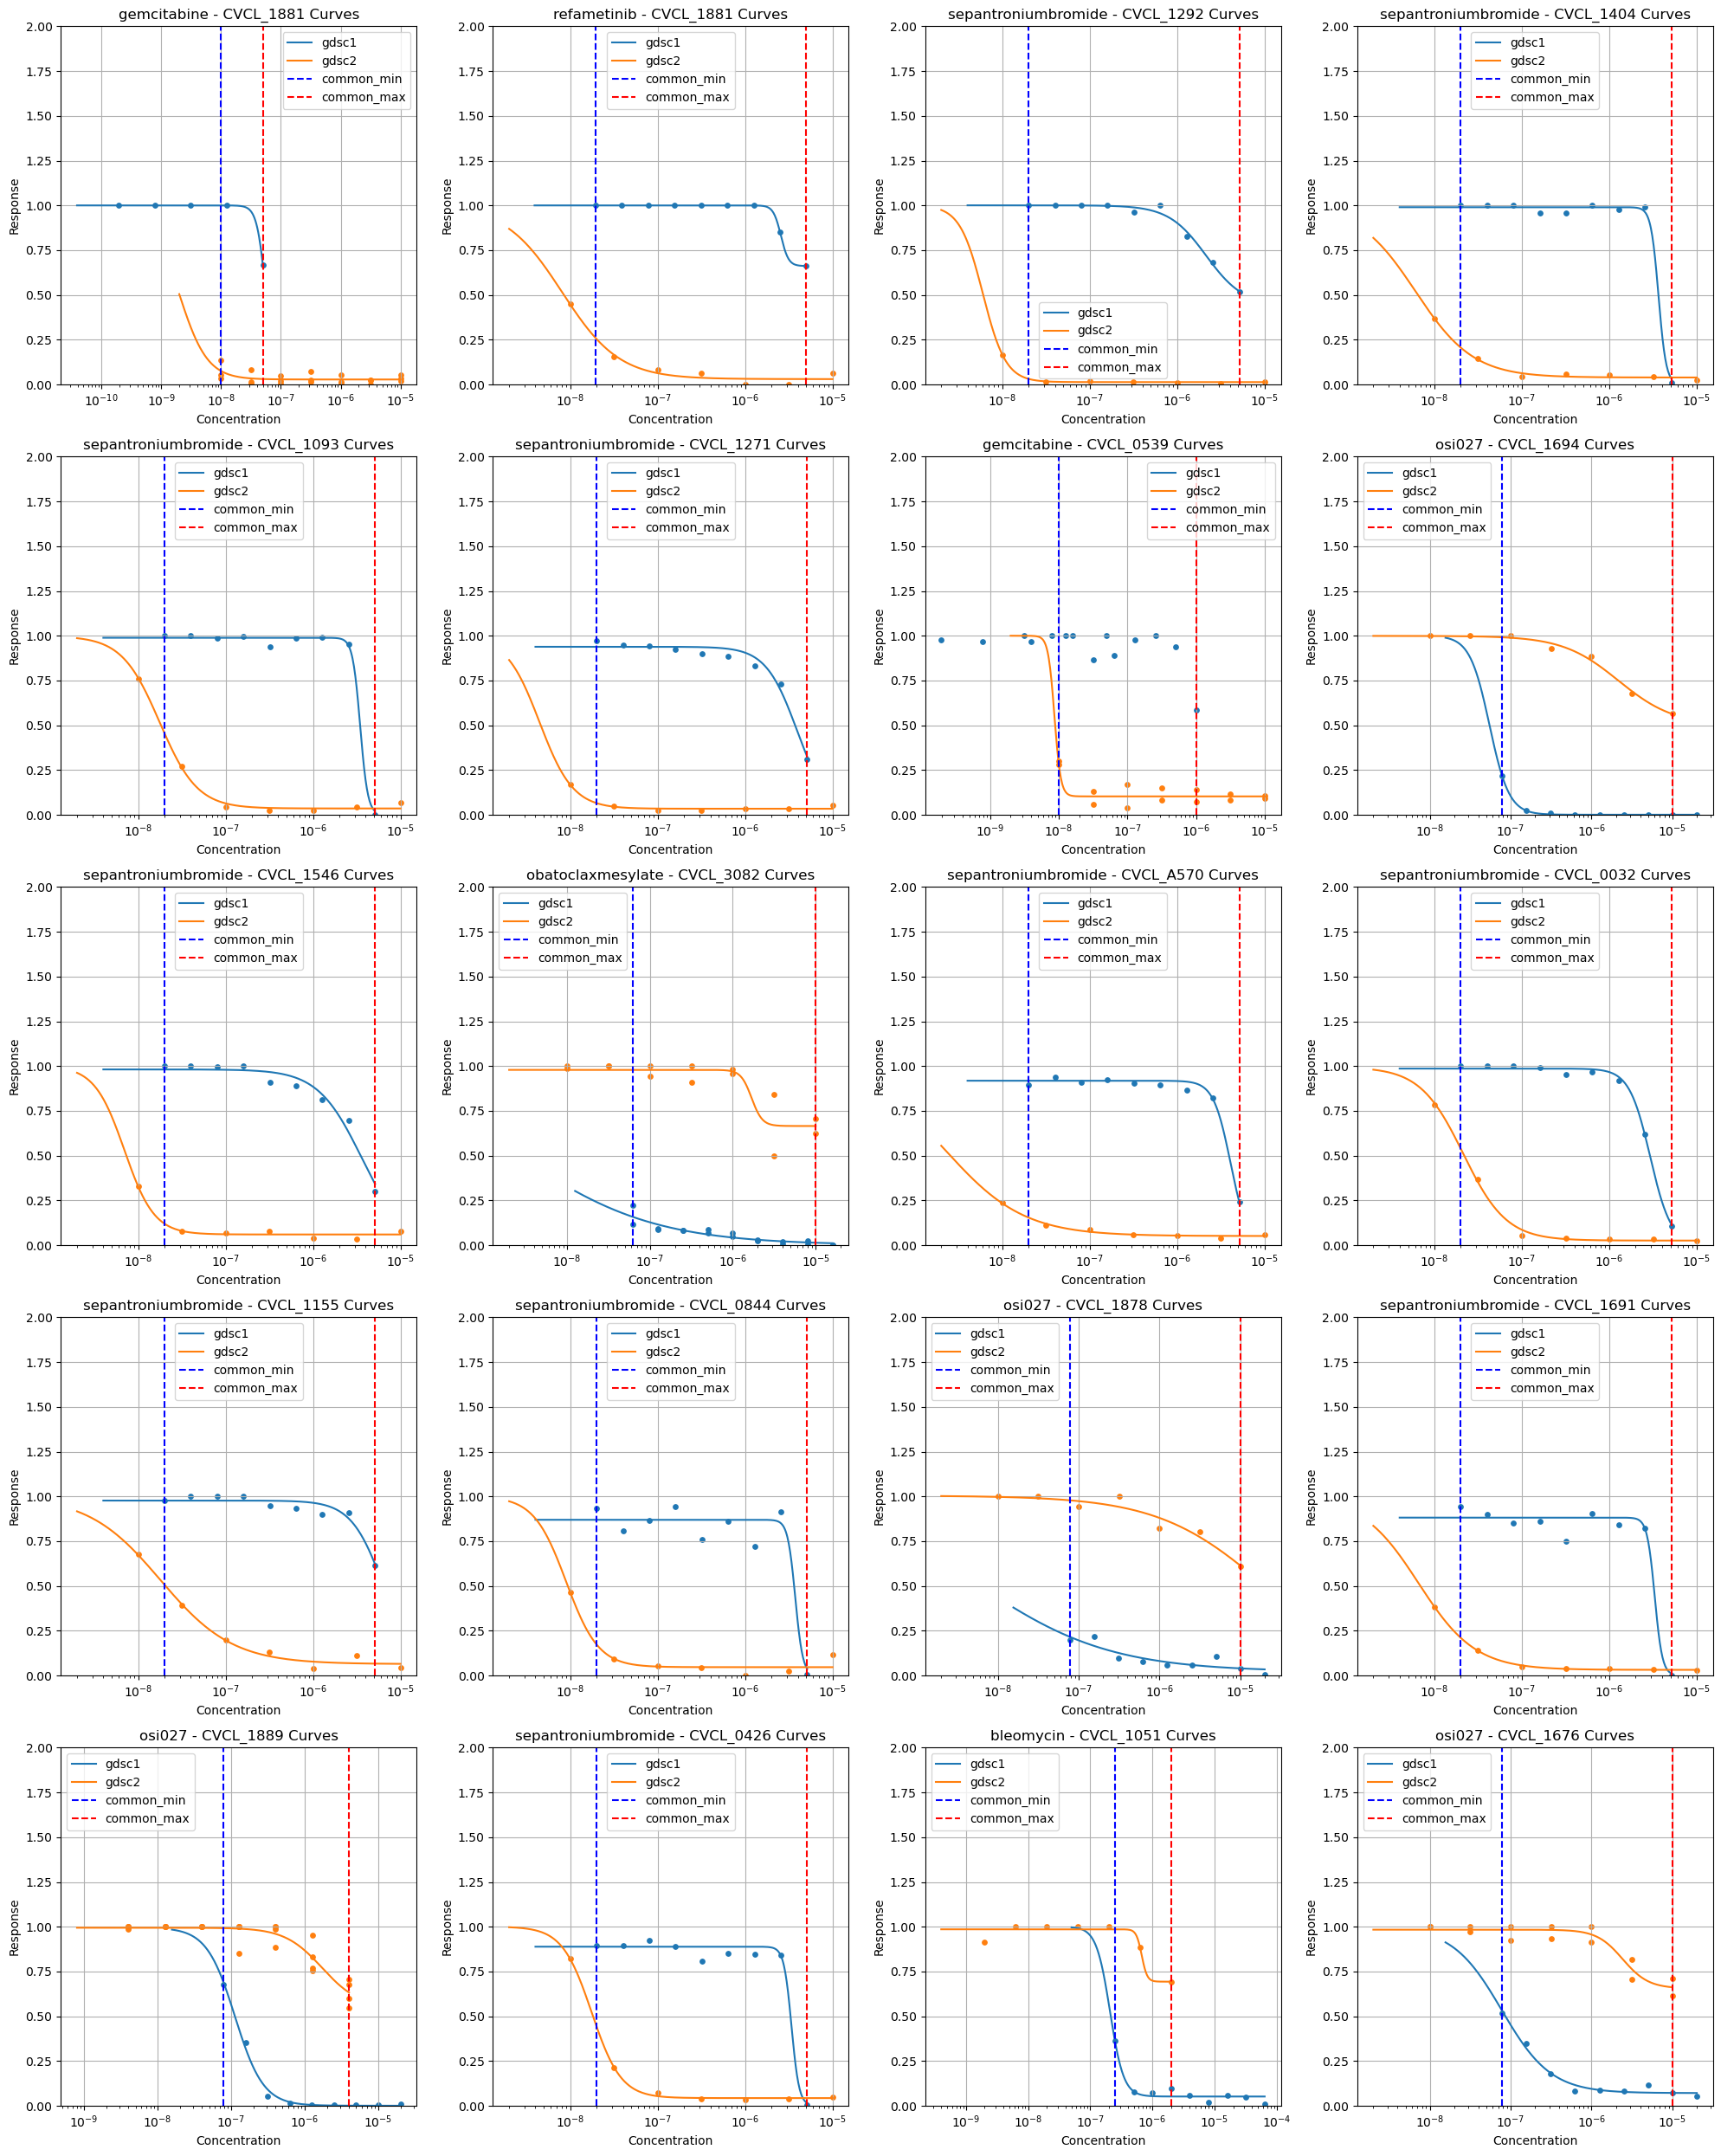

In [42]:


cell_lines = sorted_ABC[:20]

num_plots = 20
num_cols = 4  # We will arrange the plots in 4 columns.
num_rows = num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 25))

plot_number = 0  # Initialize plot_number
for _, row in cell_lines.iterrows():
    if plot_number >= num_plots:  # Check if we've reached the number of required plots
        break
    ax = axs[plot_number // num_cols, plot_number % num_cols]
    Plotting.multiple_sigmoid_curves(gdsc1, gdsc2, row['drug'], row['cell_line'].upper(), common_conc=common_conc, ax=ax)
    plot_number += 1  # Increase plot_number with each loop iteration

# Hide any unused subplots
for i in range(plot_number, num_plots):
    axs[i // num_cols, i % num_cols].axis('off')

plt.tight_layout()  # optional, it increases space between plots
plt.show()


I want to see the distribution of ABC for each drug

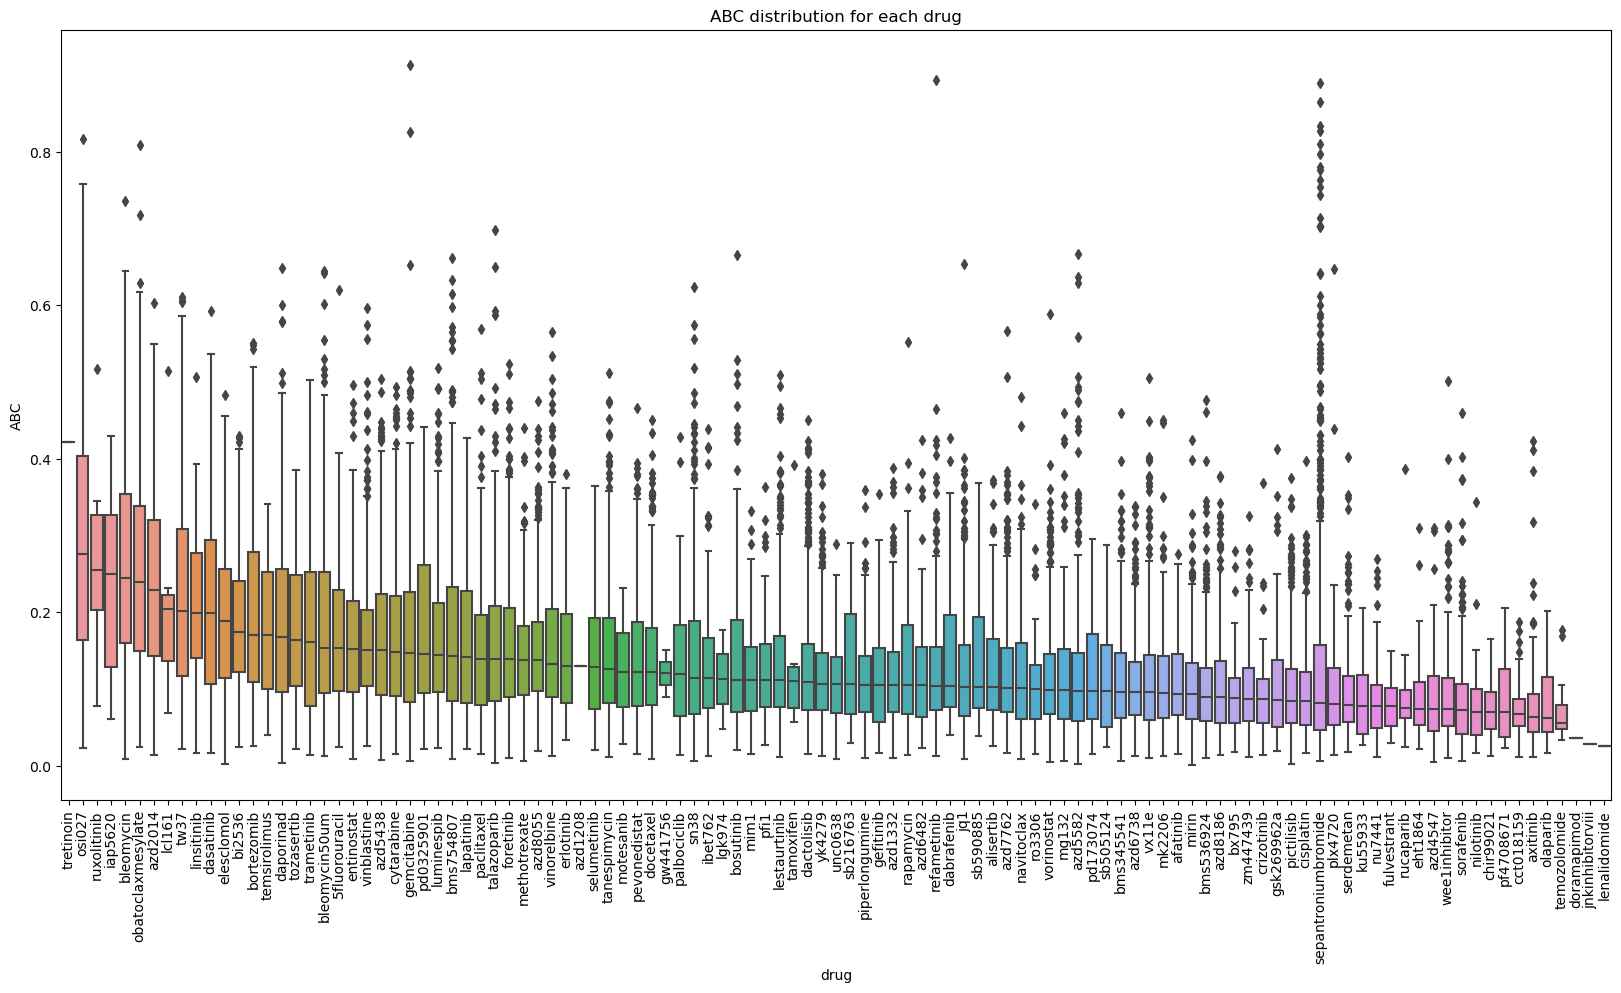

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


medians = sorted_ABC.groupby(['drug'])['ABC'].median().sort_values(ascending=False)


plt.figure(figsize=(20, 10))
sns.boxplot(x='drug', y='ABC', data=sorted_ABC, order=medians.index)
plt.xticks(rotation=90)
plt.title('ABC distribution for each drug')
plt.show()


I just wondered how ABC values would cluster together, so I'll try to use k-means clustering to find the clusters within ABC.  
First, let's determine the number of clusters.

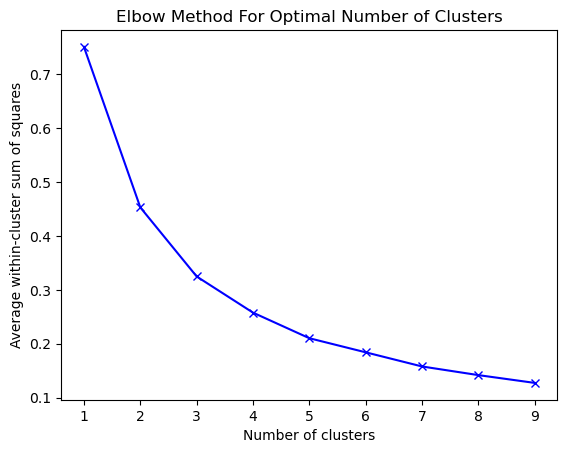

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

ABC_values = sorted_ABC['ABC'].values.reshape(-1, 1)

# Standardize the 'ABC' values
scaler = StandardScaler()
ABC_values_scaled = scaler.fit_transform(ABC_values)

# Define a range for the number of clusters
clusters_range = range(1, 10)

# Fit the KMeans model for a range of clusters and compute the total within-cluster sum of squares for each number of clusters
within_cluster_sum_of_squares = []
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(ABC_values_scaled)
    within_cluster_sum_of_squares.append(sum(np.min(cdist(ABC_values_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / ABC_values_scaled.shape[0])

# Plot the Elbow method graph
plt.plot(clusters_range, within_cluster_sum_of_squares, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()


3 looks like the optimum number of clusters

In [45]:

# Perform KMeans clustering with 3 clusters (as determined earlier)
kmeans = KMeans(n_clusters=3, random_state=0).fit(ABC_values_scaled)

# Add the cluster labels to the original dataframe
sorted_ABC['cluster'] = kmeans.labels_

# Display the first few rows of the dataframe with the cluster labels
sorted_ABC.head()


c:\Users\SerhatBeyaz\anaconda3\envs\drop2ai\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


drug  cell_line  auc_pset1  auc_pset2       ABC  \
100689          gemcitabine  cvcl_1881   0.043070   0.956055  0.913007   
100720          refametinib  cvcl_1881   0.040719   0.934184  0.893472   
72997   sepantroniumbromide  cvcl_1292   0.096083   0.985381  0.889692   
75475   sepantroniumbromide  cvcl_1404   0.061547   0.935433  0.864493   
69103   sepantroniumbromide  cvcl_1093   0.070788   0.914473  0.833561   

        cluster  
100689        1  
100720        1  
72997         1  
75475         1  
69103         1

I want to see how the clusters look like, thus, created a boxplot below.  
Based on the boxplot it can be said that:  
- cluster 0 = consistent ones (ABC between 0 - 0.18)
- cluster 2 = moderate inconsistency (ABC between 0.18 - 0.3)
- cluster 1 = inconsistent (ABC above 0.3)

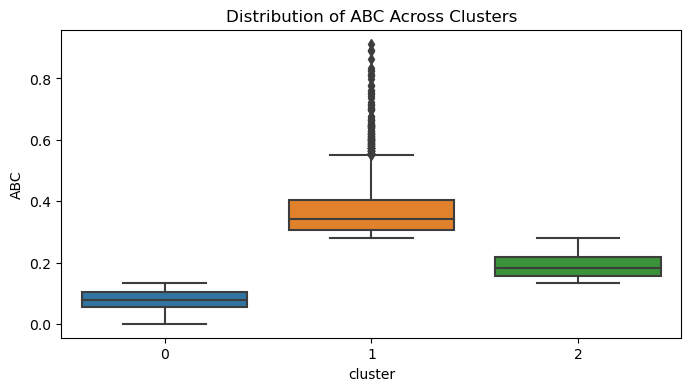

In [46]:
import seaborn as sns

continuous_vars = ['ABC']

# Plot boxplots for each continuous variable
for var in continuous_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=var, data=sorted_ABC)
    plt.title(f'Distribution of {var} Across Clusters')
    plt.show()

I also wondered, how many times a given drug is classified as inconsistent, which gives a better idea of the worst performing drugs.  

In [47]:
cluster_counts = sorted_ABC.groupby(['drug', 'cluster']).size().reset_index(name='counts')

cluster_mapping = {0: 'consistent', 1: 'inconsistent', 2: 'moderate inconsistency'}
cluster_counts['cluster'] = cluster_counts['cluster'].map(cluster_mapping)


pivot_df = cluster_counts.pivot_table(values='counts', index='drug', columns='cluster', fill_value=0)



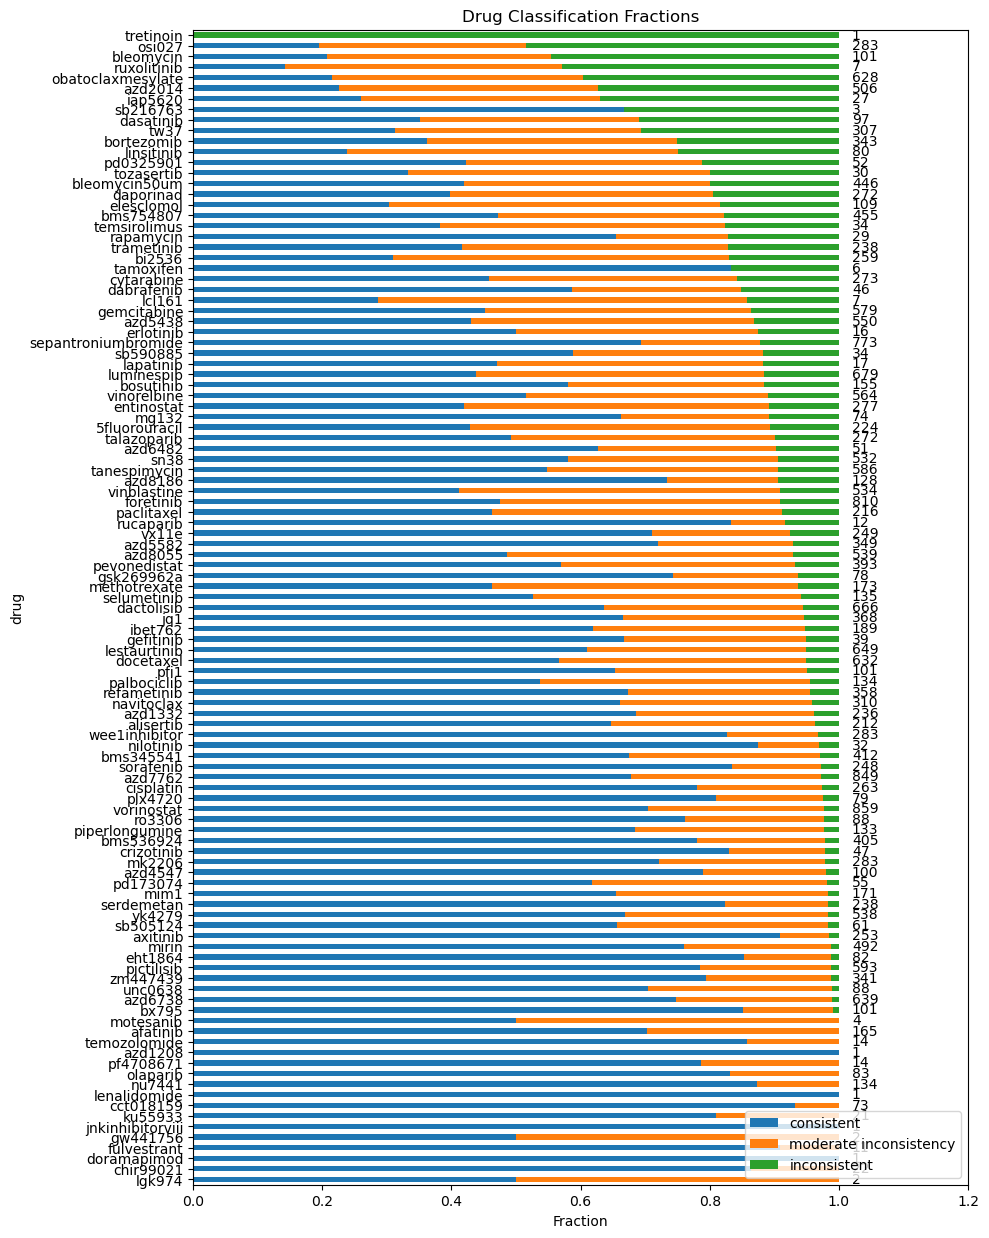

In [48]:
# Store the total counts before normalizing
total_counts = cluster_counts.groupby('drug')['counts'].sum()

# Normalize the counts to get fractions
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Sort DataFrame based on 'inconsistent' in descending order
pivot_df = pivot_df.sort_values('inconsistent', ascending=True)

# Plot fractions as horizontal stacked bar plot
ax = pivot_df.loc[:, ['consistent', 'moderate inconsistency', 'inconsistent']].plot.barh(stacked=True, figsize=(10,15))

# Annotate total counts
for i, drug in enumerate(pivot_df.index):
    ax.text(1.02, i, total_counts[drug], va='center')  # the x position 1.02 is after the end of the bar (which goes till 1.0)

plt.xlabel('Fraction')
plt.title('Drug Classification Fractions')
plt.xlim(0, 1.2)  # To make space for the annotations

ax.legend(loc='lower right')
plt.show()


Last but not least, what happens if we throw some of the inconsistent drug from the whole dataset, and then calculate the correlation

By excluding 4 drugs, overall correlation goes from 0.70 to 0.73 (Pearson)

In [49]:
drugs_to_exclude = ['obatoclaxmesylate', 'azd2014', 'osi027', 'tw37']

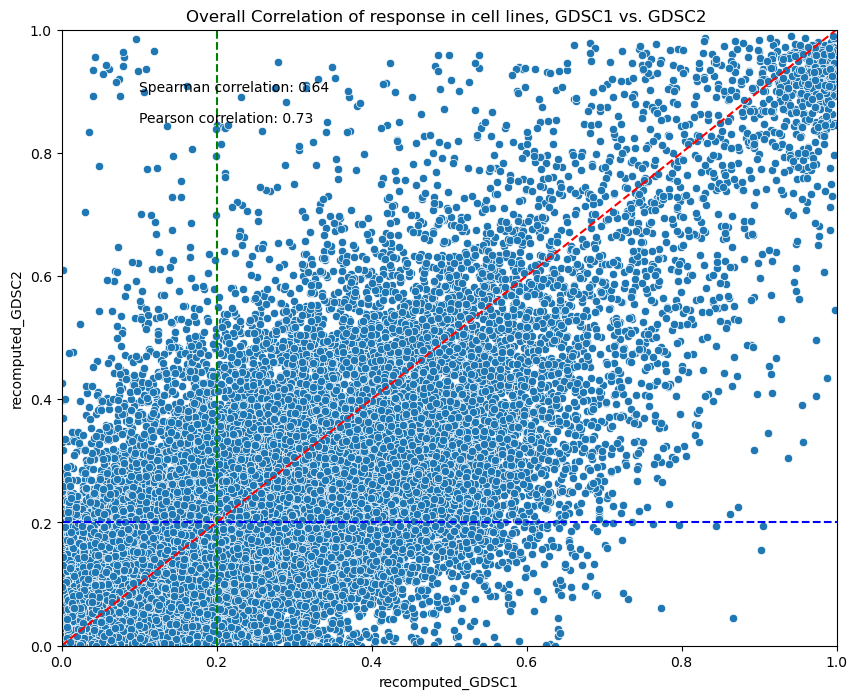

In [50]:
Plotting.correlation_plot_whole_pSet(gdsc1, gdsc2, "recomputed", drugs_to_exclude)

### Any correlation between ABC and Seeding Density?

In [51]:
gdsc1_seed = pd.read_csv("../../data/meta/gdsc1_seeding_density.csv")
gdsc2_seed = pd.read_csv("../../data/meta/gdsc2_seeding_density.csv")
gdsc1_seed.head()
gdsc2_seed.head()

cell_line    drug  SEEDING_DENSITY
0  CVCL_0589  123138           5000.0
1  CVCL_0589  123829           5000.0
2  CVCL_0589  150412           5000.0
3  CVCL_0589    1807           5000.0
4  CVCL_0589    1818           5000.0

In [52]:
merged_seed = pd.merge(gdsc1_seed, gdsc2_seed, on=['cell_line', 'drug'], how = 'left', suffixes=['_gdsc1', '_gdsc2'])
merged_seed['cell_line'] = merged_seed['cell_line'].str.lower()

In [53]:

ABC_seeds = pd.merge(sorted_ABC, merged_seed, on=['cell_line', 'drug'], how= 'left')


ABC_seeds['density_diff'] = ABC_seeds['SEEDING_DENSITY_gdsc1'] - ABC_seeds['SEEDING_DENSITY_gdsc2']
ABC_seeds.head()

drug  cell_line  auc_pset1  auc_pset2       ABC  cluster  \
0          gemcitabine  cvcl_1881   0.043070   0.956055  0.913007        1   
1          refametinib  cvcl_1881   0.040719   0.934184  0.893472        1   
2  sepantroniumbromide  cvcl_1292   0.096083   0.985381  0.889692        1   
3  sepantroniumbromide  cvcl_1404   0.061547   0.935433  0.864493        1   
4  sepantroniumbromide  cvcl_1093   0.070788   0.914473  0.833561        1   

   SEEDING_DENSITY_gdsc1  SEEDING_DENSITY_gdsc2  density_diff  
0                15000.0                  400.0       14600.0  
1                15000.0                  400.0       14600.0  
2                    NaN                 1000.0           NaN  
3                    NaN                  625.0           NaN  
4                    NaN                  325.0           NaN

In [54]:
import pandas as pd
import numpy as np
from scipy import stats

def correlation_seed(df):

    # Remove rows with NaN or Inf
    df = df.replace([np.inf, -np.inf], np.nan)  # replace inf with NaN
    df = df.dropna(subset=['ABC', 'density_diff'])  # drop rows with NaN in 'ABC' or 'density_diff'

    
    drugs = df['drug'].unique()
    
    correlation_results = {}  # to store the correlation results

    # iterate over each drug
    for drug in drugs:
        # get subset of dataframe for the current drug
        filtered_df = df[df['drug'] == drug]

       
        #filtered_df = filtered_df[(filtered_df['auc_pset1'] > 0.1) & (filtered_df['auc_pset2'] > 0.1)  ]
        #filtered_df = filtered_df[filtered_df['cluster']  == 1]
        
        if len(filtered_df) > 5:
        # calculate Spearman correlation coefficient between ABC and density_diff
            corr, p_value = stats.spearmanr(filtered_df['ABC'], filtered_df['density_diff'])


            # store the result in dictionary
            drug_key = f"{drug}*" if p_value < 0.05 else drug
            correlation_results[drug_key] = {'correlation': corr, 'p_value': p_value, 'num_rows': len(filtered_df)}
        else:
            pass

    return correlation_results



In [55]:
def plot_correlation_seed(results):
    # Sort results 
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1]['correlation'], reverse=True))

    drugs = [f"{drug} (n={result['num_rows']})" for drug, result in sorted_results.items()]
    correlations = [result['correlation'] for result in sorted_results.values()]

    plt.figure(figsize=(15, 5))  # increased figure size for better visibility
    plt.bar(drugs, correlations)
    plt.xlabel('Drugs')
    plt.ylabel('Correlation')
    plt.title('Correlation between ABC and density_diff for each drug (stars indicate p<0.05)')
    plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees for better visibility
    plt.ylim(-1,1)
    plt.show()



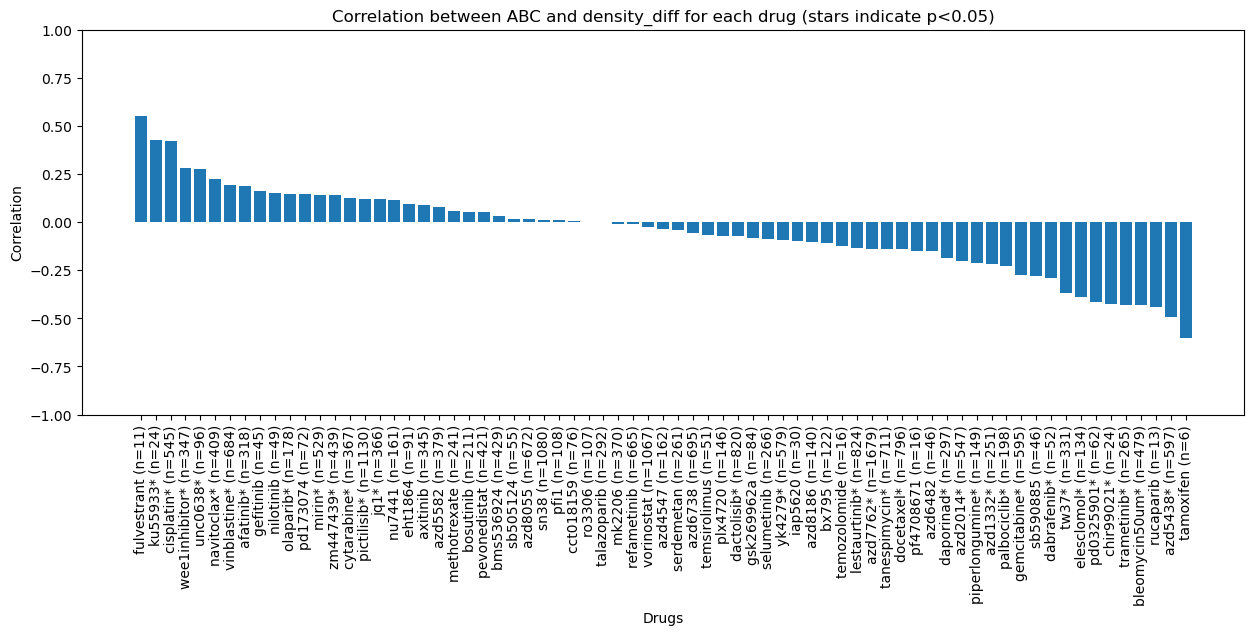

In [56]:
res2 = correlation_seed(ABC_seeds)
plot_correlation_seed(res2)

In [57]:
def correlation_cell_line(df):

    # Remove rows with NaN or Inf
    df = df.replace([np.inf, -np.inf], np.nan)  # replace inf with NaN
    df = df.dropna(subset=['ABC', 'density_diff'])  # drop rows with NaN in 'ABC' or 'density_diff'

    cell_lines = df['cell_line'].unique()

    correlation_results = {}  # to store the correlation results

    # iterate over each cell line
    for cell_line in cell_lines:
        # get subset of dataframe for the current cell line
        filtered_df = df[df['cell_line'] == cell_line]

        if len(filtered_df) > 5:
            # calculate Spearman correlation coefficient between ABC and density_diff
            corr, p_value = stats.spearmanr(filtered_df['ABC'], filtered_df['density_diff'])

            # store the result in dictionary
            cell_line_key = f"{cell_line}*" if p_value < 0.05 else cell_line
            correlation_results[cell_line_key] = {'correlation': corr, 'p_value': p_value, 'num_rows': len(filtered_df)}
        else:
            pass

    return correlation_results


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_correlations(correlation_results):
    # Extract the correlation values
    correlations = [value['correlation'] for value in correlation_results.values()]

    # Create a histogram of correlation values
    plt.figure(figsize=(10, 6))
    sns.histplot(correlations, kde=True, bins=30)
    plt.title('Distribution of Spearman Correlations')
    plt.xlabel('Spearman Correlation')
    plt.ylabel('Frequency')

    # Highlight correlations that are statistically significant
    significant_corr = [value['correlation'] for key, value in correlation_results.items() if '*' in key]
    sns.histplot(significant_corr, kde=True, color='red', bins=30)

    plt.legend(labels=['All correlations', 'Significant correlations (p < 0.05)'])
    plt.show()


c:\Users\SerhatBeyaz\anaconda3\envs\drop2ai\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


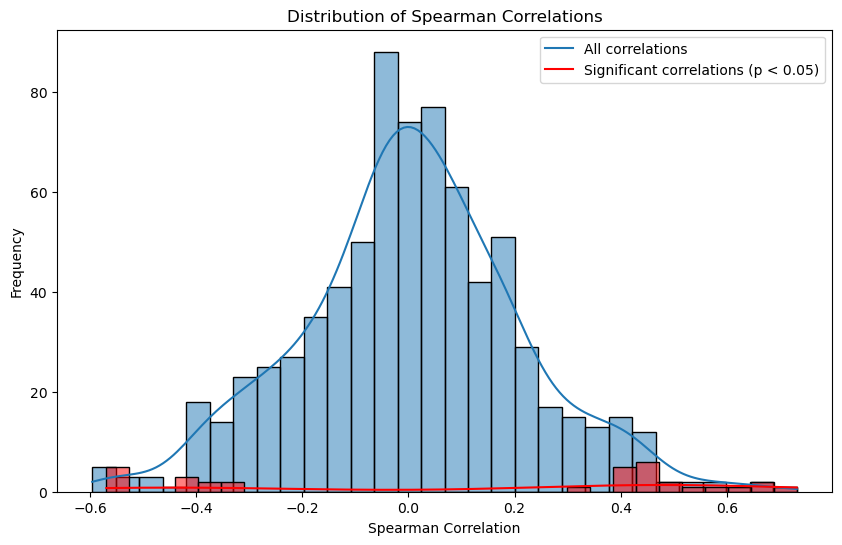

In [59]:
test = correlation_cell_line(ABC_seeds)
visualize_correlations(test)

In [60]:
def visualize_significant_correlations(correlation_results):
    # Extract the significant correlation values
    significant_correlations = {key: value['correlation'] for key, value in correlation_results.items() if '*' in key}
    
    # Sort the dictionary by absolute value of correlation
    significant_correlations = {k: v for k, v in sorted(significant_correlations.items(), key=lambda item: item[1], reverse=True)}
    
    # Create a bar plot of significant correlations
    plt.figure(figsize=(10, 6))
    plt.bar(significant_correlations.keys(), significant_correlations.values())
    plt.title('Significant Spearman Correlations')
    plt.xlabel('Cell Line')
    plt.ylabel('Spearman Correlation')
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.show()


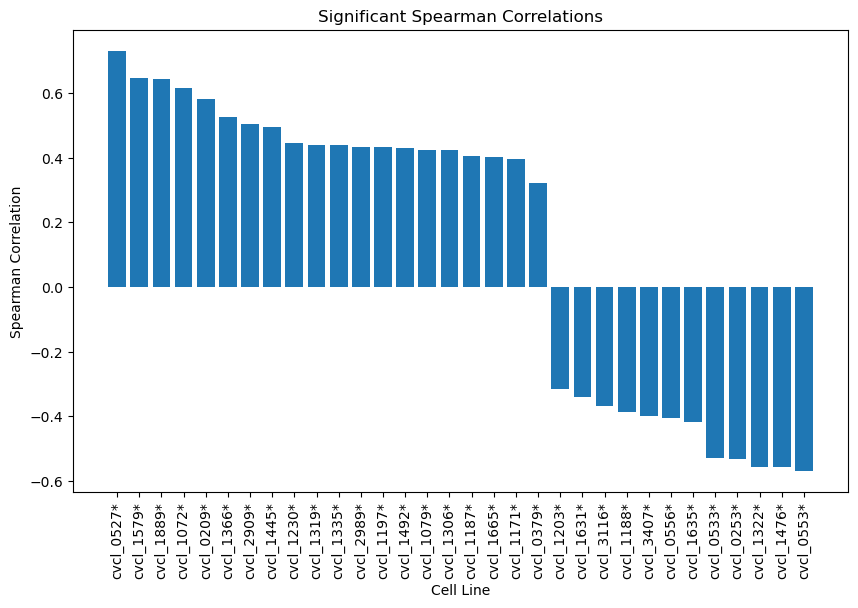

In [61]:
visualize_significant_correlations(test)

In [100]:
ABC_seeds.to_csv("../../data/meta/GDSC1_GDSC2_seeds.csv", header=True, index=False)